# To be or not to be (isomorphic)

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Graph isomorphism is a very interesting topic with many applications
spanning graph theory and network science --- check out
{doc}`the isomorphism tutorial <isomorphism>` for a deeper introduction!

Determining whether two graphs `G` and `H` are isomorphic essentially boils
down to finding a valid isomorphic mapping between the nodes in `G` and `H`,
respectively.
The process of finding such a mapping can be quite expensive.
Let's investigate with a basic pair of graphs.

In [2]:
G = nx.complete_graph(100)
H = nx.relabel_nodes(G, {n: 10 * n for n in G})

We know `G` and `H` are isomorphic *a priori*, since `H` is just a copy of `G` with
relabeled nodes.
Of course, we can verify this:

In [3]:
nx.is_isomorphic(G, H)

True

and do some basic timing to get a sense of how long it takes to make this
determination:

In [4]:
%timeit -n1 -r1 nx.is_isomorphic(G, H)

73.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Not too bad, at least for these relatively small simple graphs - but absolute
timing values aren't particularly informative.
How does this compare with a very similar example where the graphs are *not*
isomorphic?

In [5]:
H_ni = G.copy()
H_ni.remove_edge(27, 72)  # Remove a single arbitrary edge

Again, we know *a priori* that `G` and `H_ni` are not isomorphic:

In [6]:
nx.is_isomorphic(G, H_ni)

False

but even though all we've done is remove a single arbitrary edge from `H`, the
isomorphism determination is several orders of magnitude faster!

In [7]:
%timeit -n1 -r1 nx.is_isomorphic(G, H_ni)

132 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Quantitatively:

In [8]:
import timeit

iso_timing, non_iso_timing = (
    timeit.timeit(f"nx.is_isomorphic(G, {G2})", number=20, globals=globals())
    for G2 in ("H", "H_ni")
)
print(f"Relative compute time, iso/non_iso example: {iso_timing/non_iso_timing:.2f}")

Relative compute time, iso/non_iso example: 1107.18


At face value it may seem surprising that two cases which are so similar can
result in such drastic differences in computation time.

The only way to prove that two graphs are isomorphic is to find a valid
isomorphic mapping between them --- in the worst-case scenario, this could
entail searching *every possible* mapping of nodes between `G` and `H`!
Graphs that *are* isomorphic however are guaranteed to have certain properties.
For example, isomorphic graphs must have identical degree distributions.
If two graphs are shown to have *different* degree distributions, then we can
definitively say they are *not* isomorphic, without having to have
tested a single potential node mapping between `G` and `H`.
However - neither is showing that two graphs have the same degree distribution
sufficient to prove that they are isomorphic!

This asymmetry is the motivation for the [`nx.could_be_isomorphic`][nx_cbi]
function, which compares various properties of pairs of graphs to determine
whether they, well, *could be* isomorphic.
There are many properties of graphs that one could compare, ranging from the
trivial (i.e. the number of nodes) to more complex features like average
clustering.
[`nx.could_be_isomorphic`][nx_cbi] has four built-in property checks:
 1. The order of the graphs (i.e. the number of nodes)
 2. The degree of each node
 3. The number of triangles that each node contributes to in the graph
 4. The number of maximal cliques that each node contributes to in the graph

[nx_cbi]: https://networkx.org/documentation/latest/reference/algorithms/generated/networkx.algorithms.isomorphism.could_be_isomorphic.html

% ## Comparing properties
% 
% TODO: Add a section here visualizing degree, triangles, and cliques on some
% example graphs.

## Exploring properties on the graph atlas

So - we have properties of graphs that we can compare to determine whether or
not two graphs *may* be isomorphic.
We also know that some properties are more expensive to compute than others.
An obvious next question then is: how "good" are these various properties
in filtering out non-isomorphic graphs?
For instance, if degree distribution alone is sufficient to prove that two graphs
are not isomorphic in the vast majority of cases, then a good rule of thumb
might be to test degree distribution first in `could_be_isomorphic`, since the
degree distribution is so quick to compute (compared to triangles or cliques).

Answering this question in general is probably not possible, but perhaps we
can build some intuition by exploring the question on a manageable set of
possible graphs.
For example, we can use the [`nx.graph_atlas_g`][nx_gag] to investigate these
properties on all fully-connected simple graphs with 7 nodes.

[nx_gag]: https://networkx.org/documentation/latest/reference/generated/networkx.generators.atlas.graph_atlas_g.html

In [9]:
atlas = nx.graph_atlas_g()[209:]  # Graphs with 7 nodes start at idx 209
print(f"{len(atlas)} graphs with 7 nodes.")

# Limit analysis to fully-connected graphs
atlas = [G for G in atlas if nx.number_connected_components(G) == 1]
print(f"{len(atlas)} fully-connected graphs with 7 nodes.")

1044 graphs with 7 nodes.
853 fully-connected graphs with 7 nodes.


Now let's examine the properties of these graphs.
Let's define a few property-extraction shortcuts to save ourselves some typing:

In [10]:
from itertools import chain
from collections import Counter

degree = lambda G: sorted(d for _, d in G.degree())
triangles = lambda G: sorted(nx.triangles(G).values())
cliques = lambda G: sorted(Counter(chain.from_iterable(nx.find_cliques(G))).values())

# Map each callable to a more detailed name - this will be useful for e.g.
# labeling plots
name_property_mapping = {
    "degree distribution": degree,
    "triangle distribution": triangles,
    "maximal clique distribution": cliques,
}

And from here, let's compare the graphs to each other!
The simplest way to do so is simply to brute-force compare each graph to every
other:

In [11]:
def property_matrix(property):
    """`property` is a callable that returns the property to be compared."""
    return np.array(
        [[property(G) == property(H) for H in atlas] for G in atlas],
        dtype=bool,
    )

Let's start with some sanity-checking.
From the definition of the graph atlas, we'd expect that *none* of the graphs
are isomorphic with any other (except with themselves).
If we translate this expectation to our `property_matrix`, we'd expect the
`isomorphic` property matrix to be the identity matrix - i.e. with the only
`True` values lying along the diagonal.

In [12]:
is_iso = np.array([[nx.is_isomorphic(G, H) for H in atlas] for G in atlas], dtype=bool)
np.array_equal(is_iso, np.eye(len(atlas), dtype=bool))

True

Sanity-check passed --- now let's move on to the property comparison:

In [13]:
import time

p_mats = []
for name, property in name_property_mapping.items():
    # Do some (very) rough timing of the property computation
    tic = time.time()
    pm = property_matrix(property)
    toc = time.time()
    print(f"{toc - tic:.3f} sec to compare {name} for all graphs")
    p_mats.append(pm)

# Unpack results
same_d, same_t, same_c = p_mats

4.214 sec to compare degree distribution for all graphs


40.622 sec to compare triangle distribution for all graphs


53.415 sec to compare maximal clique distribution for all graphs


Let's look at the rough timing first.
Again, we have to be careful about drawing general conclusions because we're
only working with such a small subset of graphs.[^1]
That being said, we note that computing/comparing degree distribution is
roughly an order of magnitude faster than `cliques` or `triangles`, which are
(at least for these graphs) of the same order in terms of computation time.

[^1]: As graphs get larger the complexity of the relationships they capture
      can increase greatly!

How about the properties themselves:

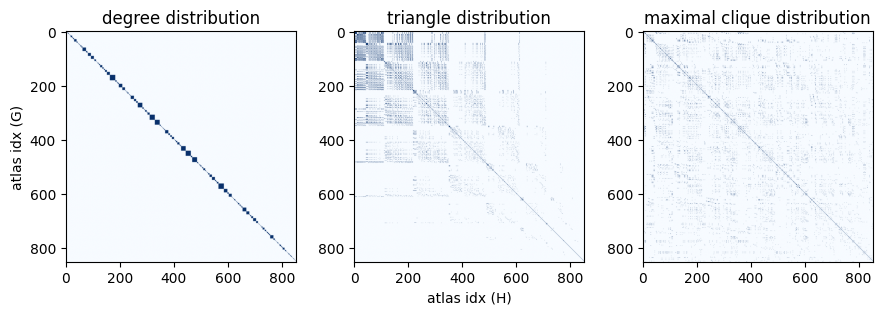

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

for a, pname, pm in zip(ax, name_property_mapping, p_mats):
    a.imshow(pm, cmap=plt.cm.Blues)
    a.set_title(pname)

ax[1].set_xlabel("atlas idx (H)")
ax[0].set_ylabel("atlas idx (G)")
fig.tight_layout()

One thing that immediately jumps out is that all graphs with identical
degree distribution appear to be organized such that they are adjacent to
each other.
A closer look at the [`nx.graph_atlas_g`][nx_gag] docstring explains why:
degree sequence is one of the properties by which the graphs are sorted in
the atlas.

Another thing we might notice is that the graph pairs with identical triangle
distributions are concentrated towards the upper-left corner of the matrix.
This too makes sense --- the atlas is ordered by (among other things) increasing
degree sequence.
Therefore the graphs with the lowest indices have the smallest
values in degree sequence.
A triangle requires *at least 3 nodes* to have degree of at least 2 - which
means the upper-left corner of the matrix contains all the graph pairs where there
are no triangles, with the propensity for triangles generally increasing with
increasing degree distribution (from upper left to lower right).

Let's quantify the results.
Of the 853 fully-connected graphs of 7 nodes, how many of them have them
have the same properties?
We can sum over the property masks to answer this question, though we have to
remember to:
 1. Ignore the diagonal, i.e. don't include the comparison of each graph with
    itself, and
 2. We were lazy in the computation of the properties and ended up comparing
    each graph to each other twice (i.e. `G` to `H` and `H` to `G`), so we
    also need to account for that.

In [15]:
import pandas as pd

num_same = {
    f"Same {pname}": (pm & ~is_iso).sum() // 2
    for pname, pm in zip(name_property_mapping, p_mats)
}

# Use pandas to get a nice html rendering of our tabular data
pd.DataFrame.from_dict(num_same, orient="index")

,0
Same degree distribution,3048
Same triangle distribution,9696
Same maximal clique distribution,6437


We can also look at combinations of properties - for example: the number of
graphs that have the same degree distribution **and** triangle distribution:

In [16]:
same_dt = same_d & same_t & ~is_iso
print(
    f"Number of graph pairs with same degree and triangle distributions: {same_dt.sum() // 2}"
)

Number of graph pairs with same degree and triangle distributions: 270


That's a pretty strong filter! The total number of non-isomorphic pairs of
fully-connected graphs of 7 nodes is: $\frac{853^{2} - 853}{2} = 363378$.
Filtering by degree, triangles, or cliques alone results in several thousand
candidates, but combining properties makes for an even stronger filter in
determining whether graphs *could* be isomorphic.

Let's take a look at some of these graph pairs.

In [17]:
candidates = zip(*np.where(same_dt))

# Filter out the duplicates
graph_pairs = []
seen = set()
for pair in candidates:
    if pair[::-1] not in seen:
        graph_pairs.append(pair)
        seen.add(pair)

True

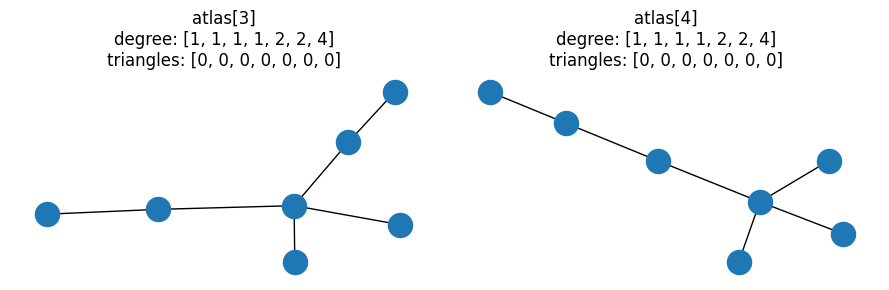

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

# First pair of graphs with same degree and triangle distributions
pair = graph_pairs[0]
G, H = (atlas[idx] for idx in pair)

for idx, a in zip(pair, ax):
    G = atlas[idx]
    nx.draw(G, ax=a)
    a.set_title(f"atlas[{idx}]\ndegree: {degree(G)}\ntriangles: {triangles(G)}")
fig.tight_layout()

nx.could_be_isomorphic(G, H, properties="dt")

This matches our expectations, and is a nice illustration of how checking
properties is not sufficient to prove graphs are isomorphic.
It's a little boring though as there are no triangles - let's look at a pair
where the graphs contain triangles:

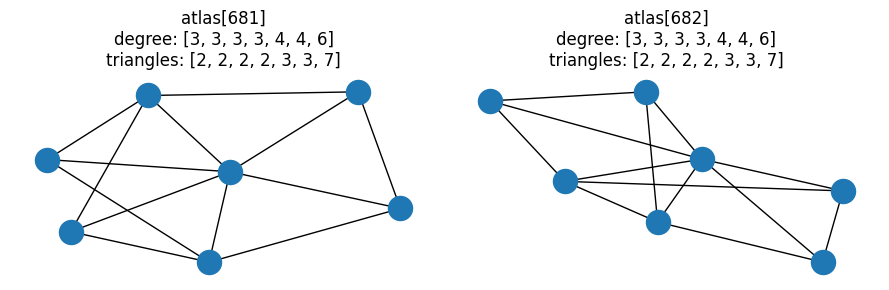

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

# Last pair of graphs with same degree and triangle distributions
pair = graph_pairs[-1]

for idx, a in zip(pair, ax):
    G = atlas[idx]
    nx.draw(G, ax=a)
    a.set_title(f"atlas[{idx}]\ndegree: {degree(G)}\ntriangles: {triangles(G)}")
fig.tight_layout()

% TODO: add bit about comparing properties independently vs. together

Let's refine our investigation even further --- of the 363378 possible graph
pairs, how many have identical combined degree-triangle distributions, but
*different* clique distributions?
In other words, for how many of these graph pairs is the distribution of
maximal cliques the determining factor in whether or not the graphs could be
isomorphic?

Let's start by combining our masks computed from properties independently to
constrain the search space:

In [20]:
diff_c = same_d & same_t & ~same_c & ~is_iso

print(
    "Number of graph pairs with same degree and triangle distributions\n"
    f"but different clique distributions: {diff_c.sum() // 2}"
)

candidates = zip(*np.where(diff_c))

# Filter out the duplicates
graph_pairs = []
seen = set()
for pair in candidates:
    if pair[::-1] not in seen:
        graph_pairs.append(pair)
        seen.add(pair)

Number of graph pairs with same degree and triangle distributions
but different clique distributions: 107


Here's the "simplest" of these candidate pairs, i.e. the pair with the lowest
degree sequence:

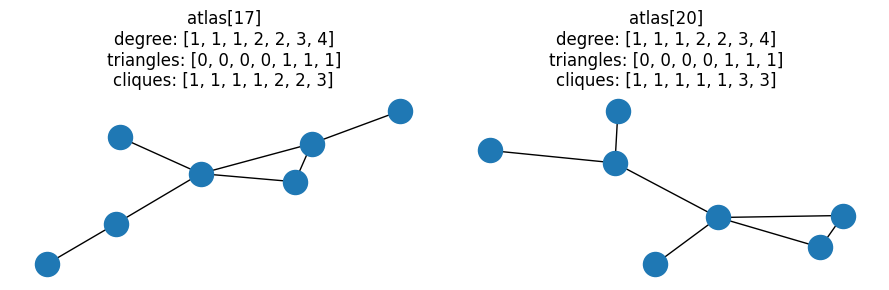

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

# Last pair of graphs with same degree and triangle distributions
pair = graph_pairs[0]

for idx, a in zip(pair, ax):
    G = atlas[idx]
    nx.draw(G, ax=a)
    a.set_title(
        f"atlas[{idx}]\ndegree: {degree(G)}\ntriangles: {triangles(G)}\ncliques: {cliques(G)}"
    )
fig.tight_layout()

At this point, we've filtered down all the possible combinations of fully-connected
7-node graphs to 107 candidates that have the same degree distributions,
triangle distributions, and *different* clique distributions.
However - recall that to this point we have only compared the properties
*independently* - i.e. we compared the sorted degree sequences, then the sorted
triangle distributions etc.
This is less-restrictive than if we had considered the *combined* properties of
the nodes.
In other words, rather than comparing degree, then triangles - what if we compute
the degree *and* number of triangles *for each node*, then sort the nodes
based on this combined degree-and-number-of-triangles feature.
`could_be_isomorphic` compares the combined properties, so
we can answer our question by applying it to our candidate pairs:

In [22]:
# All graph pairs that have the same *combined* degree-and-triangle distributions
# but a different clique distributions
resulting_pairs = [
    (int(G), int(H))
    for (G, H) in graph_pairs
    if nx.could_be_isomorphic(atlas[G], atlas[H], properties="dt")
]
resulting_pairs

[(318, 325), (473, 479)]

Of all fully-connected graphs with 7 nodes, there are only two unique pairs of
graphs that have the same degree-and-triangle combined properties, but
different clique distributions.

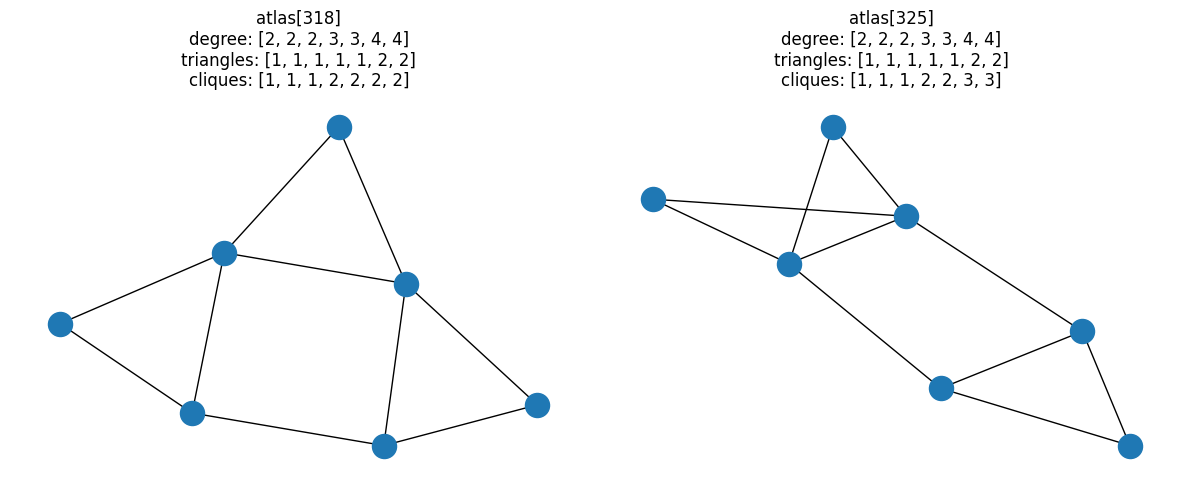

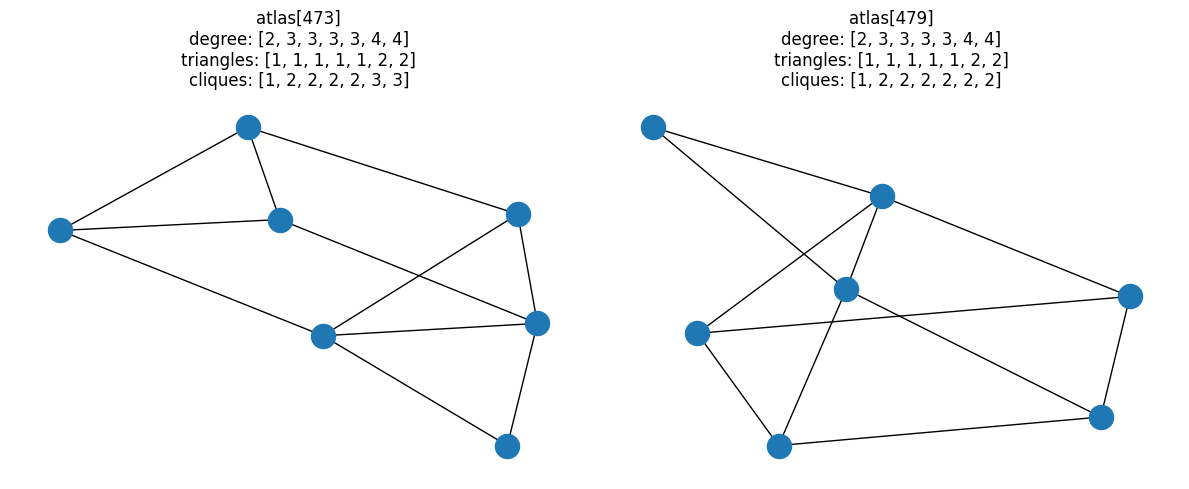

In [23]:
for i, pair in enumerate(resulting_pairs):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    for idx, a in zip(pair, ax):
        G = atlas[idx]
        nx.draw(G, ax=a)
        a.set_title(
            f"atlas[{idx}]\ndegree: {degree(G)}\ntriangles: {triangles(G)}\ncliques: {cliques(G)}"
        )
    fig.tight_layout()

### Inspiration

You may be wondering what motivated this particular line of investigation.
This analysis was originally performed in order to find
[test cases for `nx.could_be_isomorphic`][gh-7852].

[gh-7852]: https://github.com/networkx/networkx/pull/7852